# Quickstart on BRASS

Here we show how to use the BRASS module to estimate the association between two binary variables. We recall that other categorical variables can be transformed into binary ones through [one-hot encoding](https://en.wikipedia.org/wiki/One-hot).

The BRASS module implements the method described in [Xavier et al. (2023)](https://arxiv.org/abs/2311.05330), "Applying a new category association estimator to sentiment analysis on the Web". Please cite the paper if you use this method.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
import sys

sys.path.append("../")
import brass as br

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## 1. Generating synthetic variables

To demonstrate the method, we will use synthetic variables.

In [2]:
# Generator of dependent binary variables A and B:
Pa     = 0.2 # Probability that A=1.
Pb     = 0.1 # Probability that B=1.
deltaP = 0.3 # Boost on A: P(A=1|B=1) - P(A=1)
varmodel = br.VarGenerator(0.3, 0.2, 0.1)

In [3]:
# Generate independent variables:
n_sample = 200
As, Bs   = varmodel.sample(n_sample, seed=478)

In [4]:
# Organize as pandas DataFrame:
X = pd.DataFrame({'A': As, 'B': Bs})

# Show data:
X

,A,B
0,0,0
1,0,0
2,0,0
3,0,0
4,1,0
...,...,...
195,0,0
196,0,0
197,0,0
198,0,0


## 2. Apply the method

To apply the method, one instantiate the class `brass.AssocEstimator` with a given data:

In [5]:
# Create Bayesian model with flat prior:
estimator = br.AssocEstimator(onehot_trials=X)

Then we run an MCMC to sample the posterior for all parameters of interest:

In [6]:
# Sample model parameters (i.e. create an MCMC chain):
chain_df = estimator.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


In [7]:
# The output:
chain_df

,p00,p01,p10,p11,Pa,Pb,P(a|b),P(a|~b),P(b|a),P(b|~a),delPa,delPb
0,0.770374,0.031087,0.145126,0.053413,0.198539,0.084500,0.632110,0.158521,0.269032,0.038787,0.433571,0.184532
1,0.787994,0.020534,0.160968,0.030504,0.191472,0.051038,0.597673,0.169625,0.159314,0.025397,0.406201,0.108276
2,0.754579,0.036226,0.195369,0.013826,0.209195,0.050052,0.276236,0.205663,0.066093,0.045809,0.067040,0.016040
3,0.768568,0.017542,0.171464,0.042426,0.213890,0.059968,0.707472,0.182402,0.198354,0.022315,0.493582,0.138386
4,0.767937,0.024797,0.182278,0.024989,0.207266,0.049785,0.501930,0.191828,0.120563,0.031280,0.294663,0.070778
...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.786519,0.033618,0.156502,0.023361,0.179863,0.056979,0.409999,0.165958,0.129884,0.040990,0.230136,0.072905
9996,0.700720,0.043016,0.196849,0.059415,0.256264,0.102430,0.580049,0.219314,0.231850,0.057837,0.323785,0.129419
9997,0.768820,0.028907,0.181282,0.020991,0.202273,0.049898,0.420680,0.190802,0.103777,0.036237,0.218407,0.053879
9998,0.782339,0.024649,0.169958,0.023054,0.193012,0.047703,0.483277,0.178472,0.119441,0.030544,0.290265,0.071739


The table below explains the meaning of each column in `chain_df` in terms of probabilities relating binary variables _A_ and _B_:

| Variable | Meaning              |
| -------- | -------------------- |
| p00      | P(A=0, B=0)          |
| p01      | P(A=0, B=1)          |
| p10      | P(A=1, B=0)          |
| p11      | P(A=1, B=1)          |
| Pa       | P(A=1)               |
| Pb       | P(B=1)               |
| P(a\|b)  | P(A=1\|B=1)          |
| P(a\|~b) | P(A=1\|B=0)          |
| P(b\|a)  | P(B=1\|A=1)          |
| P(b\|~a) | P(B=1\|A=0)          |
| delPa    | P(A=1\|B=1) - P(A=1) |
| delPb    | P(B=1\|A=1) - P(B=1) |

To check if an association between the two variables was detected, you can compute the p-value of $\Delta P(A, B) \equiv P(A=1|B=1) - P(A=1)$:

In [8]:
# Compute the p-value:
estimator.compute_pvalue(chain_df['delPa'])

0.0057

Values lower than a specified [significance level](https://en.wikipedia.org/wiki/Statistical_significance) $a$ indicate that the two variables are dependent. For a single test, $a$ is commonly set to 5\%. However, beware of the [multiple comparisons problem](https://en.wikipedia.org/wiki/Multiple_comparisons_problem) (also known as the [Look-elsewhere effect](https://en.wikipedia.org/wiki/Look-elsewhere_effect)). In this case, you can use the [Bonferroni](https://en.wikipedia.org/wiki/Bonferroni_correction) or similar correction.

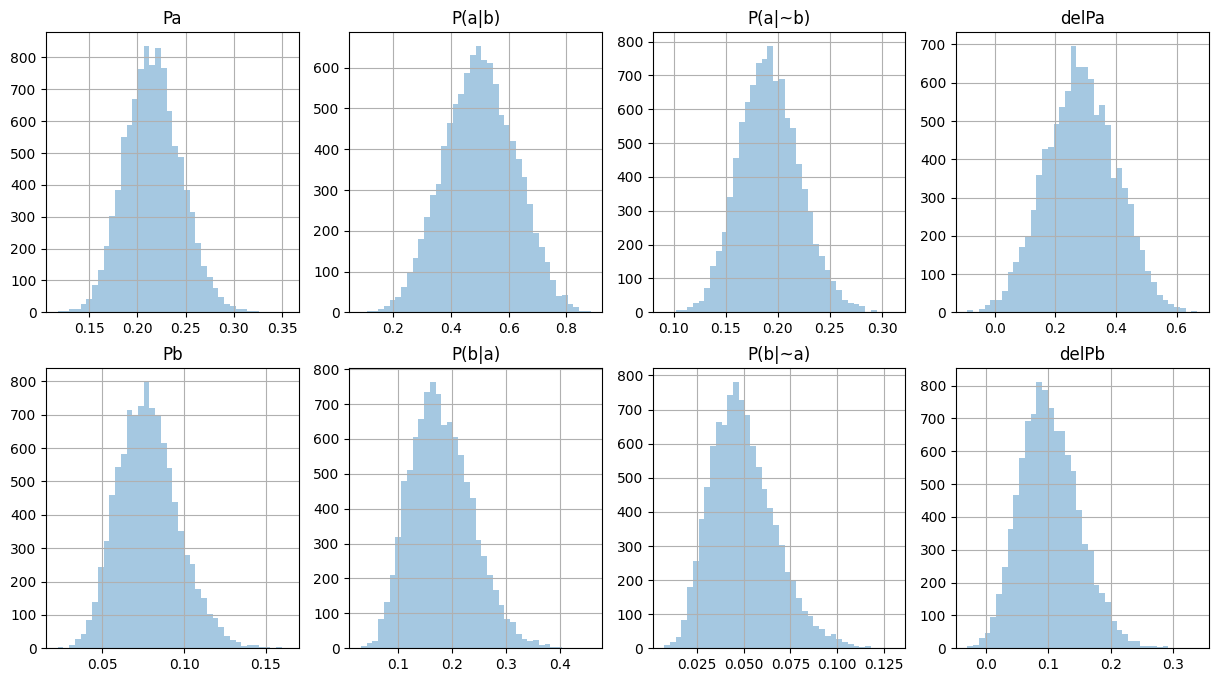

In [9]:
# Plot the marginal posteriors for some variables of interest:
estimator.plot_chain_probs(chain_df)

You can compute several summary statistics (the mean and standard deviation for $P(A=1)$, $P(A=1|B=1)$ and $\Delta P(A, B)$; as well as [Z-test](https://en.wikipedia.org/wiki/Z-test) and the p-value for $\Delta P(A, B)$) from the sampled distributions using the method below:

In [13]:
# Compute expectation values, standard deviations, z-test and p-values:
estimator.summarize_stats(chain_df, 'First Variable', 'Second Variable')

,Direction,A,B,P(A),dev P(A),P(A|B),dev P(A|B),"deltaP(A,B)","dev deltaP(A,B)",abs delta nsigma,delta p-value
0,F,First Variable,Second Variable,0.216260,0.028974,0.500709,0.121835,0.284449,0.116122,2.449572,0.0057
1,B,Second Variable,First Variable,0.078155,0.018710,0.180937,0.057151,0.102782,0.047138,2.180451,0.0057


The output contains both the results for "Forward" direction ($V_1 \rightarrow V_2$) as well as the permutation of $A$ and $B$ variables (the "Backward" direction, ($V_2 \rightarrow V_1$)).

## 3. Alternative procedures

### 3.1. Input data format

Th Bayesian model accepts data `X` in the format of numpy arrays of shape `(m, k)`, where `m` is the number of instances and `k=2` is the number of variables:

In [37]:
# Organize the data as numpy array:
X = np.column_stack((As, Bs))
X[:5]

array([[0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0]])

In [43]:
# Re-generate the model:
estimator = br.AssocEstimator(onehot_trials=X)

The model also accepts $(A, B)$ counts in this order: $(0, 0)$, $(0, 1)$, $(1, 0)$, $(1, 1)$:

In [44]:
# Transform data into counts:
pair_counts = estimator._count_onehot_pairs(X)
pair_counts

array([151,   7,  35,   7])

In [45]:
# Re-generate the model:
estimator = br.AssocEstimator(pair_counts)

### 3.2. Changing MCMC sampling parameters

In [41]:
# You can also change the MCMC sampling parameters:
short_chain_df = estimator.sample_model(n_draws=1000, n_chains=2, seed=8932821)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


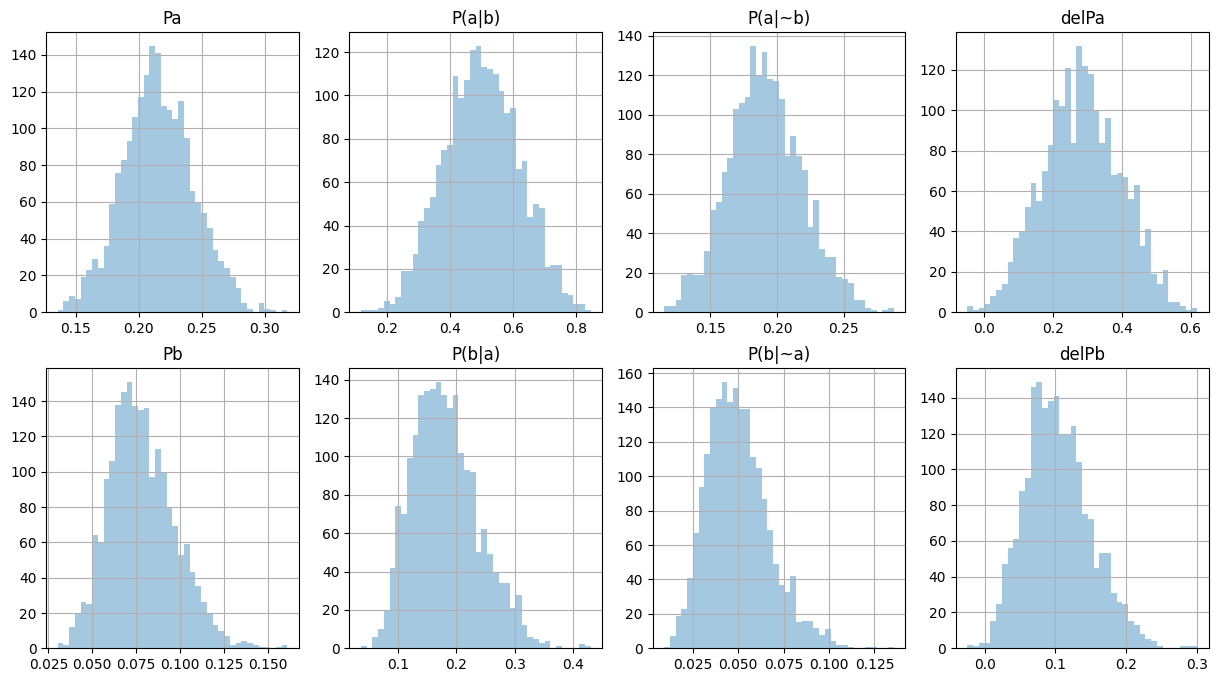

In [42]:
# Visualizing the results:
estimator.plot_chain_probs(short_chain_df)

### 3.3. Using a non-uniform prior

The [prior](https://en.wikipedia.org/wiki/Prior_probability) used in BRASS is the [Dirichlet distribution](https://en.wikipedia.org/wiki/Dirichlet_distribution). Setting $\alpha=1$ makes the prior uniform. One can change the prior parameters when instantiating the estimator:

In [39]:
# Example of how to change the prior:
new_estimator = br.AssocEstimator(pair_counts, prior_alpha=[4,2,2,1])

In [40]:
# Run chain with this new prior:
new_chain_df = new_estimator.sample_model()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pair_probs]


Sampling 4 chains for 1_000 tune and 2_500 draw iterations (4_000 + 10_000 draws total) took 3 seconds.


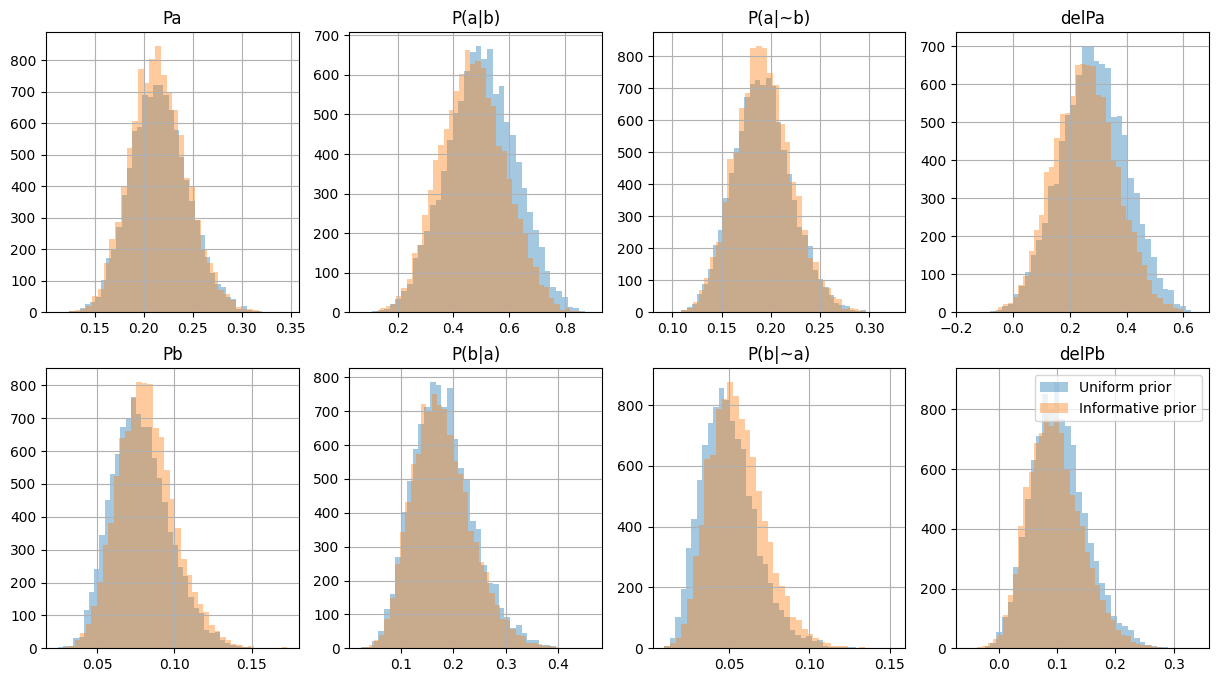

In [50]:
# Compare the two results:
estimator.plot_chain_probs(chain_df, label='Uniform prior')
new_estimator.plot_chain_probs(new_chain_df, label='Informative prior', figsize=None)
pl.legend()
pl.show()